# Рекомендация тарифов

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф.

Построим модель с максимально большим значением *accuracy*. Нужно довести долю правильных ответов по крайней мере до 0.75. Проверить *accuracy* на тестовой выборке.

# План работы
1. Загрузка библиотек и файла
2. Разбиение данных на выборки
3. Исследованиее модели
4. Проверим модель на тестовой выборке
5. Вывод

# Описание данных:

**calls** — количество звонков\
**minutes** — суммарная длительность звонков в минутах\
**messages** — количество sms-сообщений\
**mb_used** — израсходованный интернет-трафик в Мб\
**is_ultra** — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0)


## 1. Загрузка библиотек и файла

Импорт библиотек

In [ ]:
! pip install phik

In [ ]:
import pandas as pd
import seaborn as sb
import phik
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
df = pd.read_csv('/datasets/users_behavior.csv')

ознакомление с данными

In [ ]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [ ]:
df.isna().mean()

calls       0.0
minutes     0.0
messages    0.0
mb_used     0.0
is_ultra    0.0
dtype: float64

In [ ]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [ ]:
df['is_ultra'].value_counts(normalize=True)

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

<div class="alert alert-info"> <b>Комментарий студента: </b> 30 % на тарифе ультра</div>

In [ ]:
phik_overview = df.phik_matrix()

interval columns not set, guessing: ['calls', 'minutes', 'messages', 'mb_used', 'is_ultra']


In [ ]:
phik_overview['is_ultra'].sort_values(ascending=False)

is_ultra    1.000000
mb_used     0.493928
calls       0.474240
minutes     0.456533
messages    0.374044
Name: is_ultra, dtype: float64

с помощью Phik посмотрим какие переменные важны при выборе тарифа

## 2. Разбиение данных на выборки

с помощью stratify разобьем выборки по целевому признаку что бы в выборках были равные доли тарифа ультра

In [ ]:
train, test = train_test_split(df,train_size=0.6,random_state=42,stratify=df['is_ultra'])

In [ ]:
valid, test = train_test_split(test,train_size=0.5,random_state=42,stratify=test['is_ultra'])

In [ ]:
features_train = train.drop(['is_ultra'], axis=1)
target_train = train['is_ultra']
features_valid = valid.drop(['is_ultra'], axis=1)
target_valid = valid['is_ultra']

In [ ]:
train['is_ultra'].mean()

0.3065352697095436

In [ ]:
test['is_ultra'].mean()

0.30637636080870917

In [ ]:
valid['is_ultra'].mean()

0.30637636080870917

## 3. Исследованиее модели

In [ ]:
%%time

dt_best_model = None # подбор гиперпараметров решающего дерева
dt_best_result = 0

dt_best_depth = 0 # списки для построения графика
score_depth = [1, 50]
est_score_train = []
est_score_val = []
for depth in range(1, 10): # подбор глубины дерева
    score_train = []
    score_val = []
    for est in range(1,50): #подборка деревьев
        model = DecisionTreeClassifier(random_state=42, max_depth=depth) # создадим модель, указав max_depth=depth
        model.fit(features_train, target_train) # обучим модель
        score_train.append(model.score(features_train, target_train))
        result = model.score(features_valid, target_valid) #расчет точности на вал выборке
        score_val.append(result)
        score_depth.append(depth)
        if result > dt_best_result: # определение лучшей модели
            dt_best_model = model
            dt_best_result = result
            dt_best_depth = depth
    if depth == dt_best_depth: #запись списков для лучшей глубины дерева
        est_score_train = score_train.copy()
        est_score_val = score_val.copy()
print("Accuracy наилучшей модели решающего дерева:", dt_best_result)
print(dt_best_model)

Accuracy наилучшей модели решающего дерева: 0.8040435458786936
DecisionTreeClassifier(max_depth=3, random_state=42)
CPU times: user 3.11 s, sys: 5.54 ms, total: 3.11 s
Wall time: 3.12 s


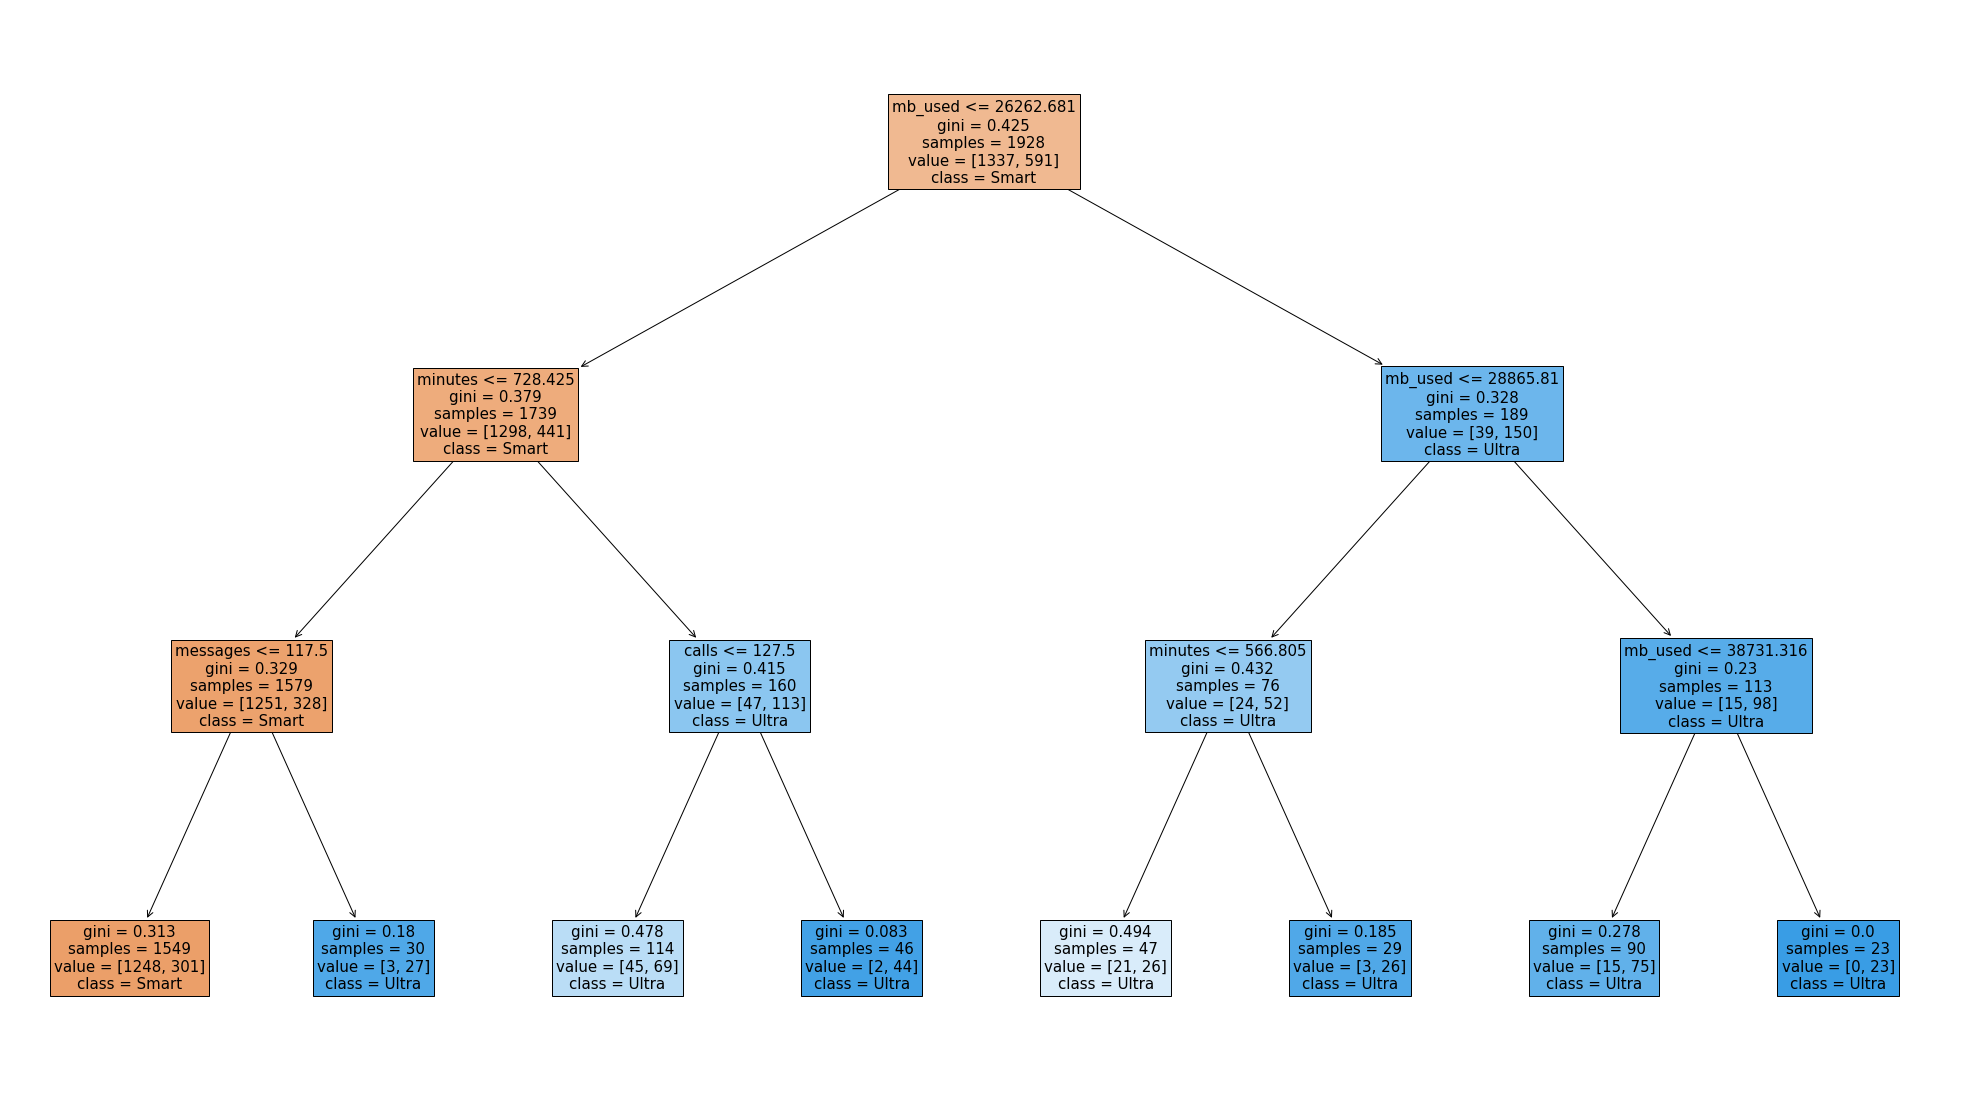

In [ ]:
import matplotlib.pyplot as plt
from sklearn import tree

fig = plt.figure(figsize=(35,20))
_ = tree.plot_tree(dt_best_model,
               feature_names=features_train.columns.values,
               class_names=['Smart','Ultra'],
               filled=True,
               fontsize = 15,
               max_depth = 3     # Это чтобы прорисовывало 3 уровня, не глубже
                  )

In [ ]:
%%time
# подбор гиперпараметров случайного леса
rf_best_model = None
rf_best_result = 0
# списки для построения графика
rf_best_depth = 0
score_depth = [1, 50]
est_score_train = []
est_score_val = []
# подбор глубины дерева
for depth in range(1, 10):
    score_train = []
    score_val = []
    #подборка деревьев
    for est in range(1,50):
        model = RandomForestClassifier(n_estimators=est, random_state=42, max_depth=depth) # создадим модель, указав max_depth=depth
        model.fit(features_train, target_train) # обучим модель
        score_train.append(model.score(features_train, target_train))
        #расчет точности на вал выборке
        result = model.score(features_valid, target_valid)
        score_val.append(result)
        score_depth.append(depth)
        # определение лучшей модели
        if result > rf_best_result:
            rf_best_model = model
            rf_best_result = result
            rf_best_depth = depth
    #запись списков для лучшей глубины дерева
    if depth == rf_best_depth:
        est_score_train = score_train.copy()
        est_score_val = score_val.copy()
print("Accuracy наилучшей модели случайного леса:", rf_best_result)
print(rf_best_model)

Accuracy наилучшей модели случайного леса: 0.8118195956454122
RandomForestClassifier(max_depth=4, n_estimators=31, random_state=42)
CPU times: user 31.1 s, sys: 204 ms, total: 31.4 s
Wall time: 31.4 s


RandomForestClassifier  ожидаемо показал лучший Accuracy = 0.81 чем DecisionTreeClassifier = 0.80

In [ ]:
model = LogisticRegression(random_state=42)
model.fit(features_train, target_train) # обучим модель
predictions_valid = model.predict(features_valid) # найдём предсказания на валидационной выборке
print('Логистичиская регрессия' , accuracy_score(target_valid , predictions_valid))

Логистичиская регрессия 0.7045101088646968


 Логистичиская регрессия показала наименьшую эффективность

## 4. Проверим модель на тестовой выборке

In [ ]:
features_test = test.drop(['is_ultra'], axis=1)
target_test = test['is_ultra']

In [ ]:
predictions_test = rf_best_model.predict(features_test) # найдём предсказания на тестовой выборке
print("Accuracy на тестовой выборке выборке: =" , accuracy_score(target_test, predictions_test))

Accuracy на тестовой выборке выборке: = 0.7947122861586314


Accuracy на тестовой выборке выборке 80% значит исследования проведены правильно.

# 5. Вывод

   В результате построения выбора модели анализирующей поведение клиентов, которые уже перешли на эти тарифы. Были получены результатты:
RandomForestClassifier = 0.81
DecisionTreeClassifier = 0.80
LogisticRegression = 0.80

Модель с максимально большим значением accuracy = 0.81  RandomForestClassifier.  Проверив accuracy на тестовой выборке получили  accuracy = 0.88.

RandomForestClassifier лучшая модель для предсказания тарифа